# Collaborative Filtering Recommendation System
## Hyun Ko, Eric Tria, Chunru Zheng

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
from sklearn.metrics.pairwise import cosine_similarity

## Step 1: Preparing Data

Data is from the [Netflix Prize Data](https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data) Kaggle dataset.

Make sure to download all the files from Kaggle before running all the cells.

**To skip** the pre-processing part, download [unscaled_title_data.csv](https://github.com/erictria/cf-tutorial/blob/main/unscaled_title_data.csv) which has 500 users and 50 movies and skip to **Step 3**

To get a bigger dataset, downlaod [rating_before_scaling.csv](https://github.com/erictria/cf-tutorial/blob/main/rating_before_scaling.csv) which has 1000 users and 500 movies.

In [ ]:
start_count = [1, 4500, 9211, 13368]
end_count = [4499, 9210, 13367, 17770]

In [ ]:
def whole_processor(file_num):
  filename = f"combined_data_{file_num}.txt"
  df = pd.read_csv(filename, header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
  df['Rating'] = df['Rating'].astype(float)

  movie_idx = df[df['Rating'].isnull()].index

  empty_list = []
  df['Movie_Number'] = np.append(empty_list, np.repeat(np.nan, len(df)))

  timeA = time.time()
  movie_count = start_count[file_num-1]
  tmp_list = []
  for i in range(len(movie_idx)-1):
    start_idx = movie_idx[i]
    end_idx = movie_idx[i+1]
    df.loc[start_idx:end_idx,'Movie_Number'] = np.repeat(movie_count, end_idx - start_idx + 1)
    movie_count += 1

  df.loc[movie_idx[-1]:,'Movie_Number'] = end_count[file_num-1]

  final_df = df[df['Rating'].notna()]
  save_filename = f"{start_count[file_num-1]}_to_{end_count[file_num-1]}.csv"
  final_df.to_csv(save_filename,index=False)
  timeB = time.time()
  print("Running time:", (timeB - timeA) / 60)
  return final_df

In [ ]:
df1 = pd.read_csv('0_to_4499.csv')
df2 = pd.read_csv('4500_to_9210.csv')
df3 = pd.read_csv('9211_to_13367.csv')
df4 = pd.read_csv('13368_to_17770.csv')

In [ ]:
all_df = pd.concat([df1,df2,df3,df4])
all_df

,Cust_Id,Rating,Movie_Number
0,1488844,3.0,1.0
1,822109,5.0,1.0
2,885013,4.0,1.0
3,30878,4.0,1.0
4,823519,3.0,1.0
...,...,...,...
26847518,1790158,4.0,17770.0
26847519,1608708,3.0,17770.0
26847520,234275,1.0,17770.0
26847521,255278,4.0,17770.0


## Step 2: Subsetting Data

In [ ]:
# Code from https://www.kaggle.com/code/laowingkin/netflix-movie-recommendation
# Extract Top 500 popular movies

f = ['count','mean']

df_movie_summary = all_df.groupby('Movie_Number')['Rating'].agg(f).sort_values(by=['count'], ascending = False)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = df_movie_summary['count'][:500].min()
movie_benchmark
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

Movie minimum times of review: 37995


In [ ]:
# Extract Top 1000 Ardent Users

df_cust_summary = all_df.groupby('Cust_Id')['Rating'].agg(f).sort_values(by=['count'], ascending = False)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = df_cust_summary['count'][:1000].min() #round(df_cust_summary['count'].quantile(0.995),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Customer minimum times of review: 2087


In [ ]:
rating_df = df.pivot_table(index=['Cust_Id'], columns='Movie_Number', values='Rating')
rating_df = pd.DataFrame(rating_df.to_records())
rating_df

,Cust_Id,28.0,30.0,143.0,175.0,191.0,197.0,241.0,290.0,299.0,...,17479.0,17482.0,17506.0,17508.0,17560.0,17621.0,17622.0,17627.0,17709.0,17764.0
0,1333,2.0,3.0,4.0,3.0,1.0,2.0,3.0,4.0,1.0,...,2.0,2.0,NaN,1.0,NaN,NaN,3.0,2.0,3.0,4.0
1,3321,4.0,5.0,3.0,NaN,4.0,NaN,NaN,4.0,4.0,...,4.0,4.0,2.0,NaN,4.0,NaN,2.0,4.0,4.0,5.0
2,3998,5.0,5.0,4.0,NaN,5.0,5.0,5.0,5.0,5.0,...,5.0,4.0,NaN,NaN,5.0,4.0,5.0,5.0,NaN,5.0
3,5980,NaN,5.0,3.0,3.0,NaN,NaN,NaN,5.0,NaN,...,5.0,NaN,5.0,5.0,3.0,NaN,4.0,5.0,NaN,5.0
4,10268,NaN,3.0,4.0,4.0,4.0,4.0,3.0,NaN,3.0,...,3.0,NaN,NaN,3.0,4.0,4.0,4.0,3.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,2637886,5.0,5.0,5.0,2.0,4.0,NaN,NaN,5.0,5.0,...,3.0,3.0,NaN,4.0,5.0,3.0,2.0,5.0,5.0,5.0
997,2640278,3.0,NaN,4.0,5.0,5.0,NaN,NaN,5.0,NaN,...,3.0,NaN,NaN,4.0,4.0,4.0,4.0,NaN,3.0,3.0
998,2640550,4.0,5.0,4.0,2.0,4.0,5.0,NaN,4.0,5.0,...,4.0,3.0,5.0,NaN,3.0,NaN,3.0,5.0,4.0,4.0
999,2640760,3.0,3.0,4.0,5.0,4.0,NaN,5.0,4.0,3.0,...,4.0,4.0,NaN,4.0,4.0,4.0,NaN,4.0,NaN,3.0


In [15]:
titles = pd.read_csv("movie_titles.csv", encoding = "unicode_escape", header = None).iloc[:,:3]
titles.columns = ["ID","year", "title"]
# titles

In [ ]:
raw_titles = [titles[titles["ID"] == float(movie_id)]["title"].values[0] for movie_id in rating_df.columns[1:]]
rating_df.columns = ["Cust_Id"] + raw_titles
# rating_df

In [ ]:
# 1000 x 500
rating_df.to_csv('rating_before_scaling.csv', index = 0)

## Step 3: Scaling

In [2]:
# 500 x 50
rating_df = pd.read_csv('unscaled_title_data.csv')
rating_df.head()

,Cust_Id,American Beauty,The Wedding Planner,Pirates of the Caribbean: The Curse of the Black Pearl,50 First Dates,What Women Want,The Bourne Supremacy,Lord of the Rings: The Fellowship of the Ring,Braveheart,Ghost,...,Independence Day,The Day After Tomorrow,Sweet Home Alabama,Con Air,The Green Mile,The Fugitive,Titanic,Indiana Jones and the Last Crusade,National Treasure,The Terminal
0,1333,4.0,NaN,2.0,3.0,3.0,3.0,5.0,4.0,2.0,...,2.0,4.0,2.0,1.0,3.0,3.0,4.0,3.0,3.0,4.0
1,3321,4.0,NaN,4.0,4.0,4.0,3.0,5.0,5.0,4.0,...,4.0,NaN,NaN,4.0,5.0,4.0,4.0,5.0,4.0,4.0
2,10268,4.0,3.0,3.0,NaN,4.0,4.0,4.0,4.0,3.0,...,4.0,4.0,3.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0
3,10374,4.0,3.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0
4,11043,3.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,...,5.0,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0


In [3]:
scaled_df = rating_df.copy().iloc[:,1:]
averages = scaled_df.mean(axis=1).values
for i in range(len(rating_df)):
    # Subtract by mean of each user, not the entire user
    scaled_df.iloc[i,:] = (scaled_df.iloc[i,:] - averages[i]) 

scaled_df = scaled_df.fillna(0) # fillna(0) should come after scaling
scaled_df.insert(loc=0, column='Cust_Id', value=rating_df["Cust_Id"])
scaled_df

,Cust_Id,American Beauty,The Wedding Planner,Pirates of the Caribbean: The Curse of the Black Pearl,50 First Dates,What Women Want,The Bourne Supremacy,Lord of the Rings: The Fellowship of the Ring,Braveheart,Ghost,...,Independence Day,The Day After Tomorrow,Sweet Home Alabama,Con Air,The Green Mile,The Fugitive,Titanic,Indiana Jones and the Last Crusade,National Treasure,The Terminal
0,1333,0.985250,0.000000,-1.014750,-0.014750,-0.014750,-0.014750,1.985250,0.985250,-1.014750,...,-1.014750,0.985250,-1.014750,-2.014750,-0.014750,-0.014750,0.985250,-0.014750,-0.014750,0.985250
1,3321,-0.175226,0.000000,-0.175226,-0.175226,-0.175226,-1.175226,0.824774,0.824774,-0.175226,...,-0.175226,0.000000,0.000000,-0.175226,0.824774,-0.175226,-0.175226,0.824774,-0.175226,-0.175226
2,10268,0.117760,-0.882240,-0.882240,0.000000,0.117760,0.117760,0.117760,0.117760,-0.882240,...,0.117760,0.117760,-0.882240,0.117760,1.117760,0.117760,0.117760,0.117760,0.117760,0.117760
3,10374,-0.708605,-1.708605,0.291395,-0.708605,-0.708605,0.291395,0.291395,0.291395,0.291395,...,0.291395,0.291395,0.291395,-0.708605,0.291395,0.291395,0.291395,0.291395,0.291395,0.291395
4,11043,-1.362473,0.637527,0.637527,0.637527,0.637527,-0.362473,-0.362473,0.637527,-0.362473,...,0.637527,-0.362473,0.637527,0.637527,0.637527,0.637527,0.637527,-0.362473,0.637527,-0.362473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2625420,1.518172,0.000000,0.000000,0.000000,0.000000,1.518172,1.518172,0.518172,0.000000,...,0.000000,0.518172,0.000000,0.000000,0.000000,-0.481828,0.518172,0.000000,0.000000,0.000000
496,2626336,0.010302,-2.989698,1.010302,-0.989698,0.010302,-1.989698,1.010302,1.010302,0.010302,...,1.010302,-0.989698,-1.989698,-0.989698,1.010302,1.010302,1.010302,0.010302,0.010302,0.010302
497,2630337,0.808479,-3.191521,0.808479,0.000000,-1.191521,0.808479,0.000000,0.808479,0.808479,...,0.808479,0.808479,0.808479,0.808479,0.808479,0.000000,-0.191521,0.808479,0.808479,0.808479
498,2634967,1.584225,-0.415775,0.584225,-0.415775,0.584225,-0.415775,1.584225,0.584225,0.584225,...,0.584225,-0.415775,-0.415775,-2.415775,1.584225,-1.415775,0.584225,0.584225,0.000000,-0.415775


## Step 4: Compare Similarities

In [4]:
def indices(lst, item):
    return [i for i, x in enumerate(lst) if x == item]

In [5]:
def return_similarity(current_rating, idx, movie_df):
    similarity_list = []
    for i in range(len(movie_df)):
        if i == idx:
            continue
        another_rating = np.array([movie_df.iloc[i,1:]]) # rating of another user
        curr_similarity = round(cosine_similarity(current_rating, another_rating)[0][0], 3)
        similarity = {
            'user_idx': i,
            'cosine_similarity': curr_similarity
        }
        similarity_list.append(similarity)

    return similarity_list

In [6]:
def plot_rating(expected_dict, idx):
    title = expected_dict.keys()
    rating = expected_dict.values()
    recommended = []
    for score in rating:
        if score > 0:
            recommended.append(True)
        else:
            recommended.append(False)
            
    df = pd.DataFrame({
        "Title": title, 
        "Expected Rating": rating, 
        "Recommended": recommended
    }).sort_values(by = "Expected Rating", ascending = False)
    plt.figure(figsize=(20, 7))
    plt.xticks(rotation=90)
    plt.title("Predicted Rating for Unwatched Movies and Recommendation")
    
    # return the plot and a dataframe of the top 10 recommended movies
    return (sns.barplot(x = "Title", y = "Expected Rating", hue = "Recommended", data = df), df.iloc[:10,:])

In [7]:
def get_similarity(idx, movie_df):
    current_rating = np.array([movie_df.iloc[idx,1:]]) # rating of the current user
  
    # BASE CASE: if the user has watched all movies, then returns nothing.
    if 0 not in current_rating: 
        print("This user has watched all the movies.")
        return -1

    similarity_list = return_similarity(current_rating, idx, movie_df)
    movie_titles = movie_df.columns[1:]
    
    ratings = current_rating[0].tolist()
    expected_dict = dict()
    for movie in movie_titles:
        rating = movie_df[movie].iloc[idx]
        
        # skip if the user has already seen a movie
        if rating != 0: 
            continue

        numerator = 0
        denominator = 0        
        for similarity in similarity_list:
            other_idx = similarity['user_idx']
            other_similarity = similarity['cosine_similarity']
            other_user_rating = round(movie_df[movie].iloc[other_idx], 3)
            
            # we do not consider the similarity of unwatched user 
            # because it only affects the denominator but not numerator
            if other_user_rating == 0: 
                continue

            # numerator is iteratively adding up each rating x each similarity score
            numerator = numerator + (other_user_rating * other_similarity)
            denominator += other_similarity

        if denominator == 0: # avoid zero division error
            expected_rating = 0
        else:
            expected_rating = round(numerator / denominator, 2)

        expected_dict[movie] = expected_rating

    return plot_rating(expected_dict, idx)

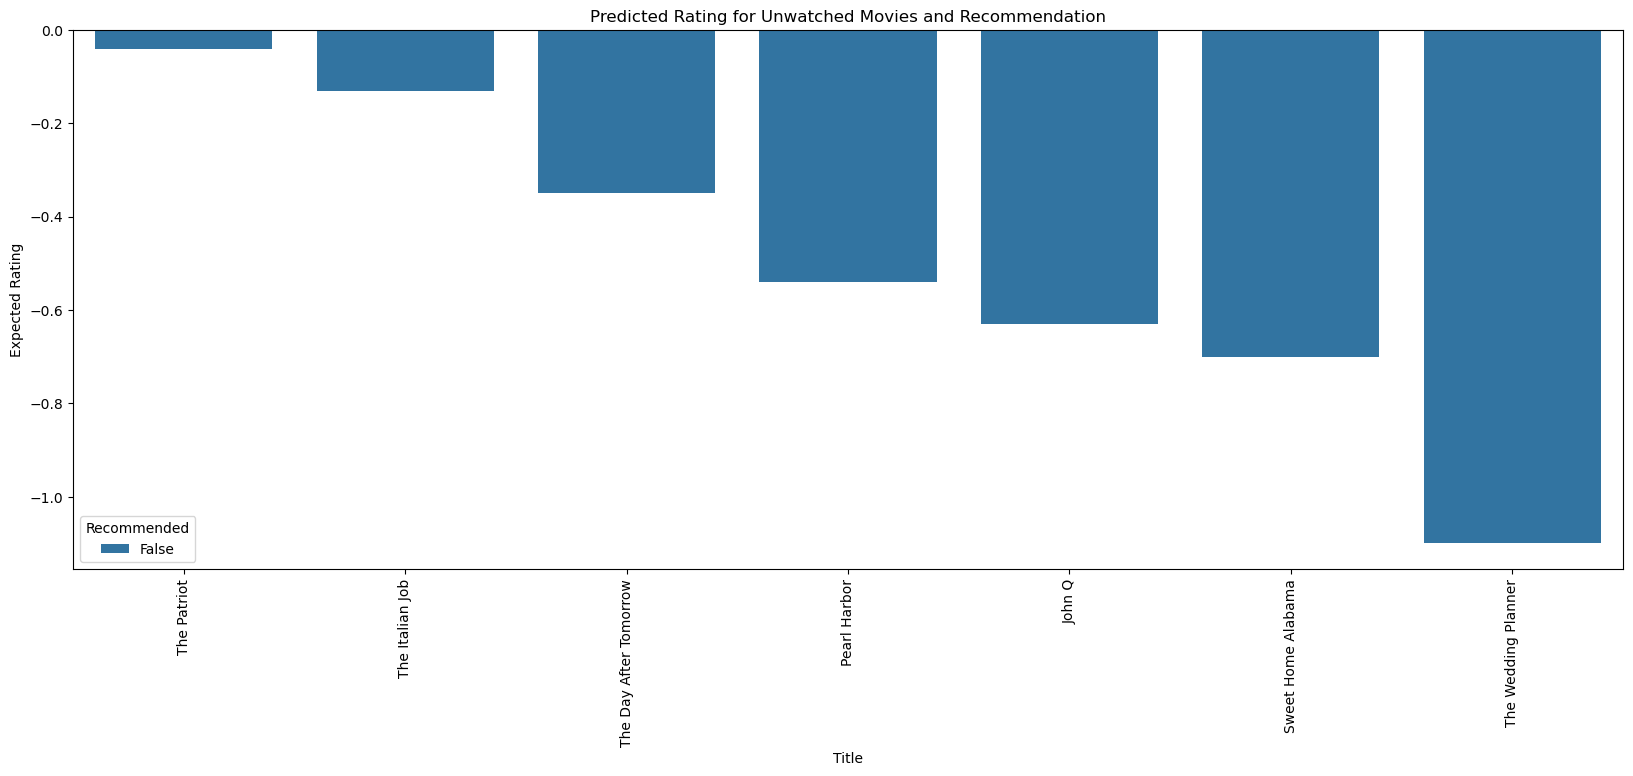

In [8]:
res1 = get_similarity(1, scaled_df)

In [9]:
res1[1]

,Title,Expected Rating,Recommended
4,The Patriot,-0.04,False
1,The Italian Job,-0.13,False
5,The Day After Tomorrow,-0.35,False
2,Pearl Harbor,-0.54,False
3,John Q,-0.63,False
6,Sweet Home Alabama,-0.70,False
0,The Wedding Planner,-1.10,False


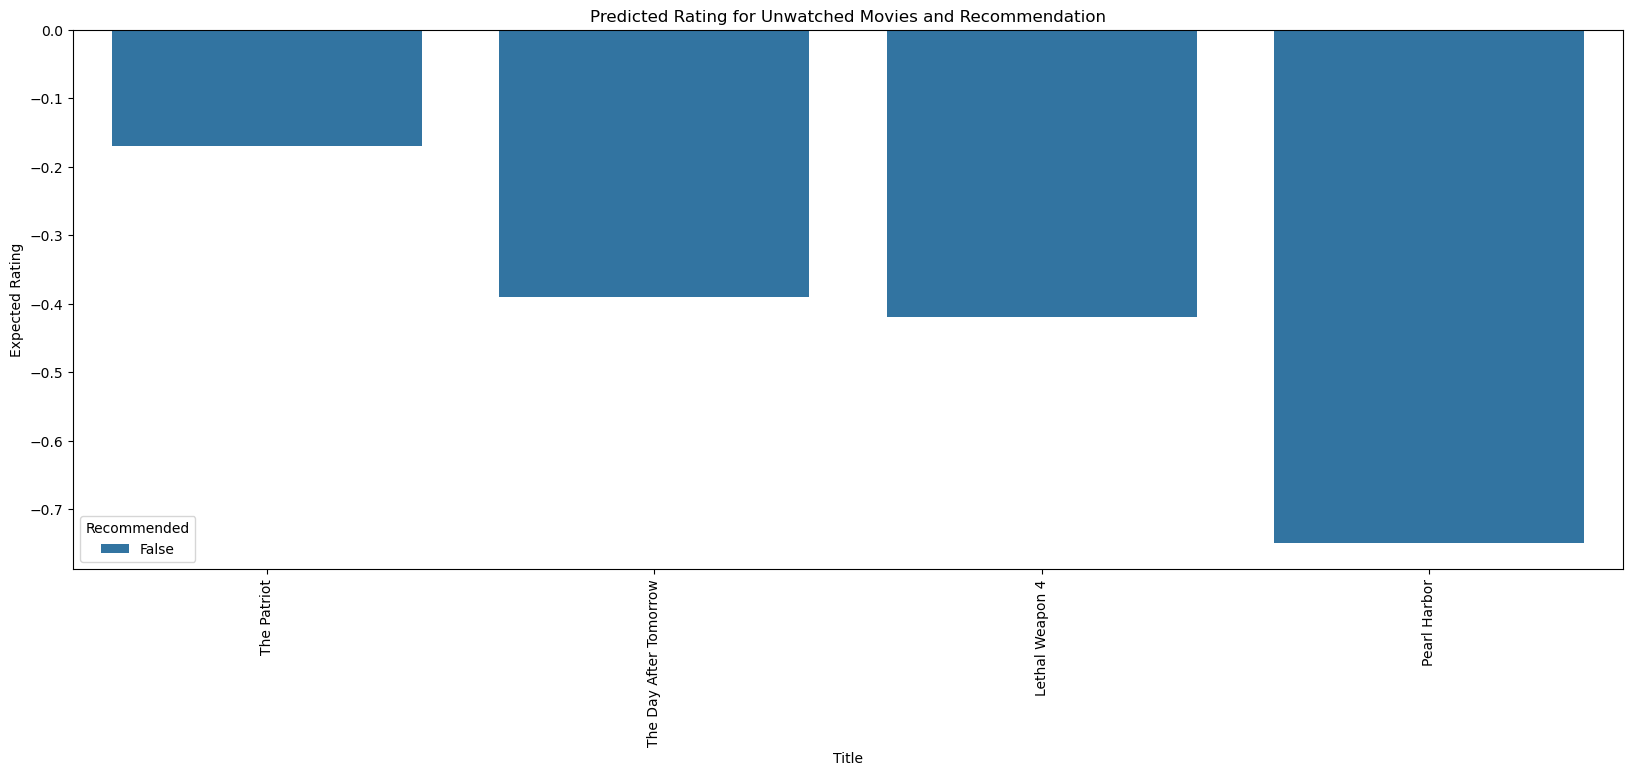

In [10]:
res2 = get_similarity(160, scaled_df)

In [11]:
res2[1]

,Title,Expected Rating,Recommended
1,The Patriot,-0.17,False
3,The Day After Tomorrow,-0.39,False
2,Lethal Weapon 4,-0.42,False
0,Pearl Harbor,-0.75,False


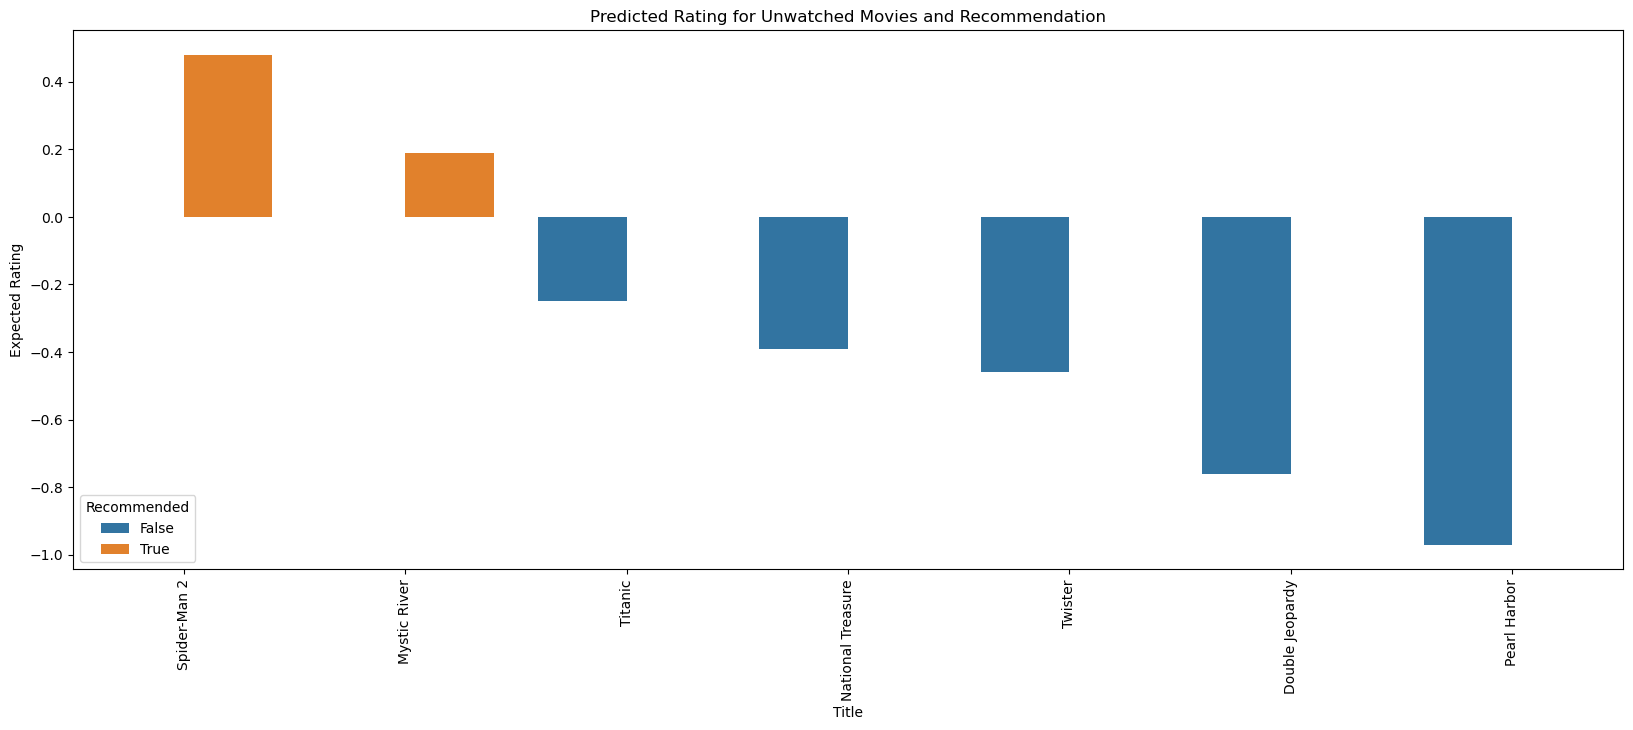

In [12]:
res3 = get_similarity(200, scaled_df)

In [13]:
res3[1]

,Title,Expected Rating,Recommended
1,Spider-Man 2,0.48,True
3,Mystic River,0.19,True
5,Titanic,-0.25,False
6,National Treasure,-0.39,False
2,Twister,-0.46,False
4,Double Jeopardy,-0.76,False
0,Pearl Harbor,-0.97,False


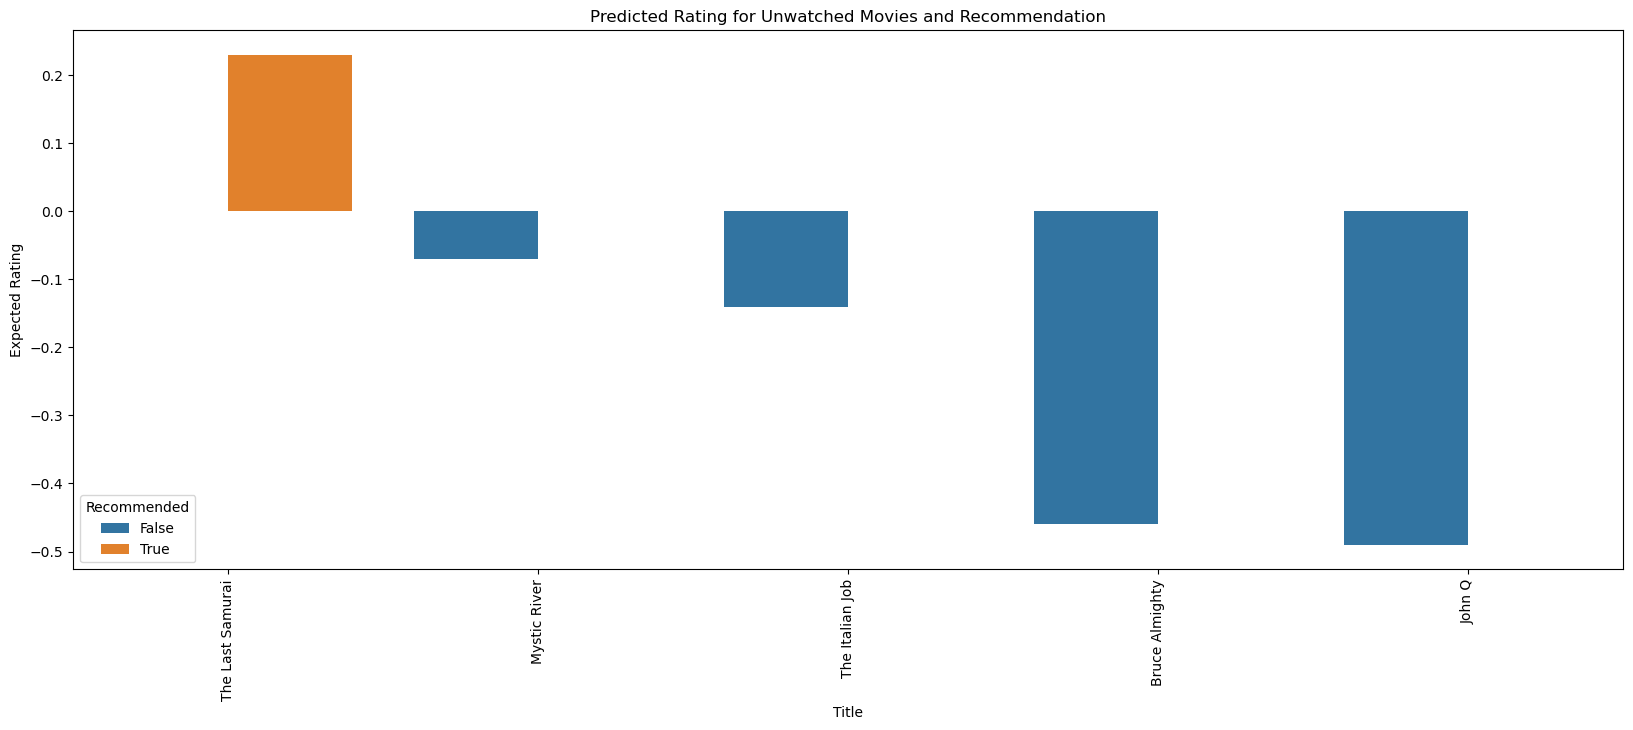

In [14]:
res4 = get_similarity(440, scaled_df)

In [15]:
res4[1]

,Title,Expected Rating,Recommended
0,The Last Samurai,0.23,True
3,Mystic River,-0.07,False
2,The Italian Job,-0.14,False
1,Bruce Almighty,-0.46,False
4,John Q,-0.49,False


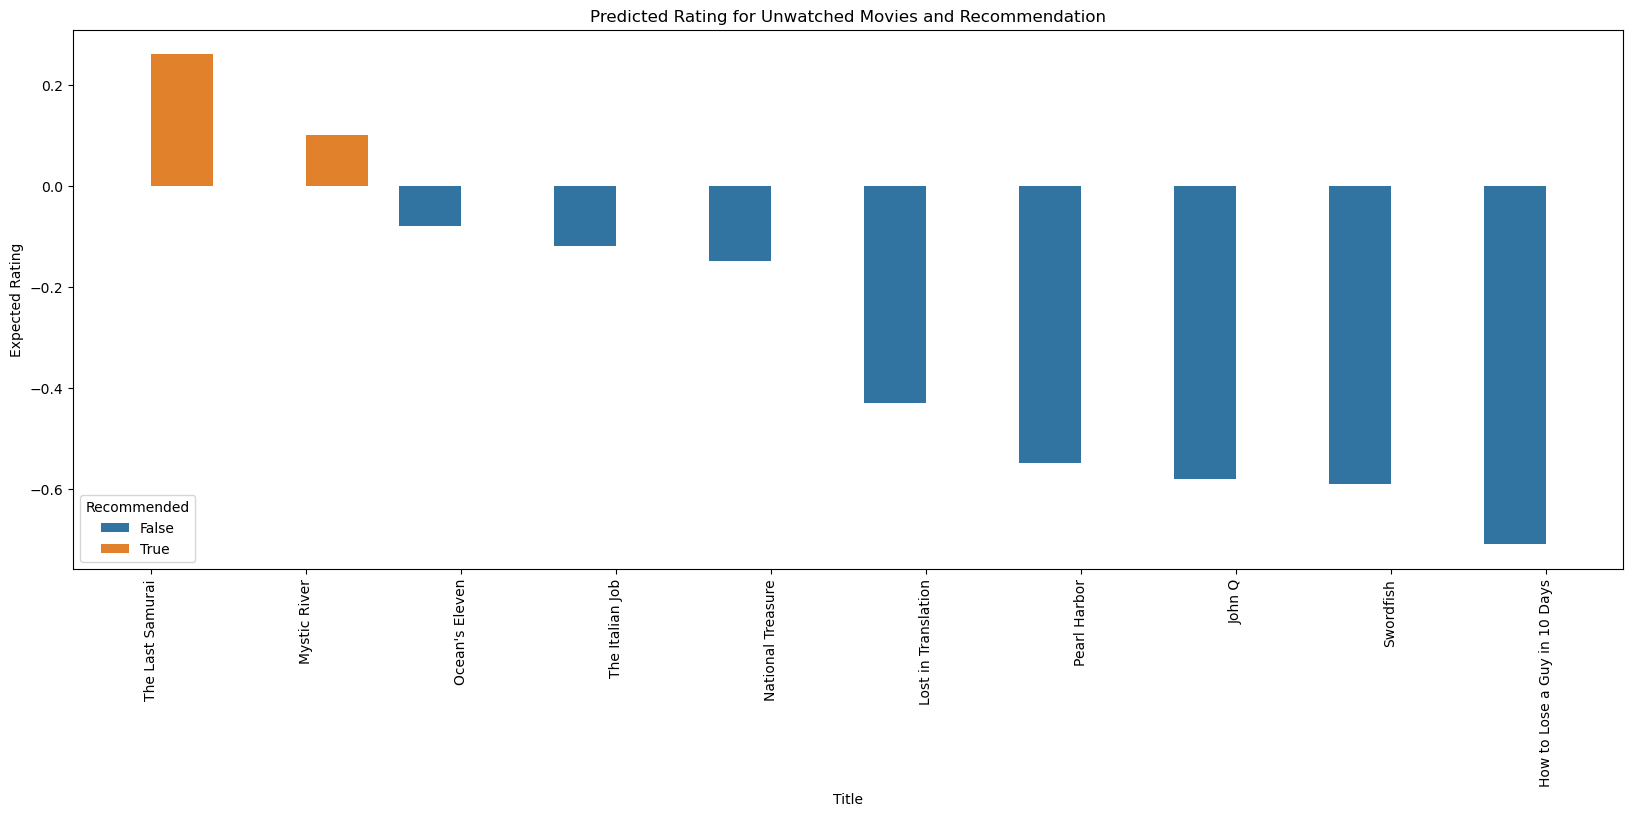

In [16]:
res5 = get_similarity(498, scaled_df)

In [17]:
res5[1]

,Title,Expected Rating,Recommended
0,The Last Samurai,0.26,True
5,Mystic River,0.10,True
8,Ocean's Eleven,-0.08,False
1,The Italian Job,-0.12,False
9,National Treasure,-0.15,False
4,Lost in Translation,-0.43,False
2,Pearl Harbor,-0.55,False
6,John Q,-0.58,False
3,Swordfish,-0.59,False
7,How to Lose a Guy in 10 Days,-0.71,False


## Additional: Using a Bigger Dataset

In [35]:
# 1000 x 500
big_rating_df = pd.read_csv('rating_before_scaling.csv')
big_rating_df.head()

,Cust_Id,Lilo and Stitch,Something's Gotta Give,The Game,Reservoir Dogs,X2: X-Men United,Taking Lives,North by Northwest,Harold and Kumar Go to White Castle,Bridget Jones's Diary,...,The Ring,Clueless,Little Black Book,Requiem for a Dream,Ghostbusters,Tomorrow Never Dies,Vanilla Sky,Harry Potter and the Sorcerer's Stone,A River Runs Through It,Shakespeare in Love
0,1333,2.0,3.0,4.0,3.0,1.0,2.0,3.0,4.0,1.0,...,2.0,2.0,NaN,1.0,NaN,NaN,3.0,2.0,3.0,4.0
1,3321,4.0,5.0,3.0,NaN,4.0,NaN,NaN,4.0,4.0,...,4.0,4.0,2.0,NaN,4.0,NaN,2.0,4.0,4.0,5.0
2,3998,5.0,5.0,4.0,NaN,5.0,5.0,5.0,5.0,5.0,...,5.0,4.0,NaN,NaN,5.0,4.0,5.0,5.0,NaN,5.0
3,5980,NaN,5.0,3.0,3.0,NaN,NaN,NaN,5.0,NaN,...,5.0,NaN,5.0,5.0,3.0,NaN,4.0,5.0,NaN,5.0
4,10268,NaN,3.0,4.0,4.0,4.0,4.0,3.0,NaN,3.0,...,3.0,NaN,NaN,3.0,4.0,4.0,4.0,3.0,4.0,4.0


In [36]:
big_scaled_df = big_rating_df.copy().iloc[:,1:]
averages = big_scaled_df.mean(axis=1).values
for i in range(len(big_rating_df)):
    # Subtract by mean of each user, not the entire user
    big_scaled_df.iloc[i,:] = (big_scaled_df.iloc[i,:] - averages[i]) 

big_scaled_df = big_scaled_df.fillna(0) # fillna(0) should come after scaling
big_scaled_df.insert(loc=0, column='Cust_Id', value=big_rating_df["Cust_Id"])
big_scaled_df

,Cust_Id,Lilo and Stitch,Something's Gotta Give,The Game,Reservoir Dogs,X2: X-Men United,Taking Lives,North by Northwest,Harold and Kumar Go to White Castle,Bridget Jones's Diary,...,The Ring,Clueless,Little Black Book,Requiem for a Dream,Ghostbusters,Tomorrow Never Dies,Vanilla Sky,Harry Potter and the Sorcerer's Stone,A River Runs Through It,Shakespeare in Love
0,1333,-0.690148,0.309852,1.309852,0.309852,-1.690148,-0.690148,0.309852,1.309852,-1.690148,...,-0.690148,-0.690148,0.000000,-1.690148,0.000000,0.000000,0.309852,-0.690148,0.309852,1.309852
1,3321,0.156003,1.156003,-0.843997,0.000000,0.156003,0.000000,0.000000,0.156003,0.156003,...,0.156003,0.156003,-1.843997,0.000000,0.156003,0.000000,-1.843997,0.156003,0.156003,1.156003
2,3998,0.232747,0.232747,-0.767253,0.000000,0.232747,0.232747,0.232747,0.232747,0.232747,...,0.232747,-0.767253,0.000000,0.000000,0.232747,-0.767253,0.232747,0.232747,0.000000,0.232747
3,5980,0.000000,1.023637,-0.976363,-0.976363,0.000000,0.000000,0.000000,1.023637,0.000000,...,1.023637,0.000000,1.023637,1.023637,-0.976363,0.000000,0.023637,1.023637,0.000000,1.023637
4,10268,0.000000,-0.649250,0.350750,0.350750,0.350750,0.350750,-0.649250,0.000000,-0.649250,...,-0.649250,0.000000,0.000000,-0.649250,0.350750,0.350750,0.350750,-0.649250,0.350750,0.350750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,2637886,1.321408,1.321408,1.321408,-1.678592,0.321408,0.000000,0.000000,1.321408,1.321408,...,-0.678592,-0.678592,0.000000,0.321408,1.321408,-0.678592,-1.678592,1.321408,1.321408,1.321408
997,2640278,-0.826577,0.000000,0.173423,1.173423,1.173423,0.000000,0.000000,1.173423,0.000000,...,-0.826577,0.000000,0.000000,0.173423,0.173423,0.173423,0.173423,0.000000,-0.826577,-0.826577
998,2640550,0.254709,1.254709,0.254709,-1.745291,0.254709,1.254709,0.000000,0.254709,1.254709,...,0.254709,-0.745291,1.254709,0.000000,-0.745291,0.000000,-0.745291,1.254709,0.254709,0.254709
999,2640760,-0.484659,-0.484659,0.515341,1.515341,0.515341,0.000000,1.515341,0.515341,-0.484659,...,0.515341,0.515341,0.000000,0.515341,0.515341,0.515341,0.000000,0.515341,0.000000,-0.484659


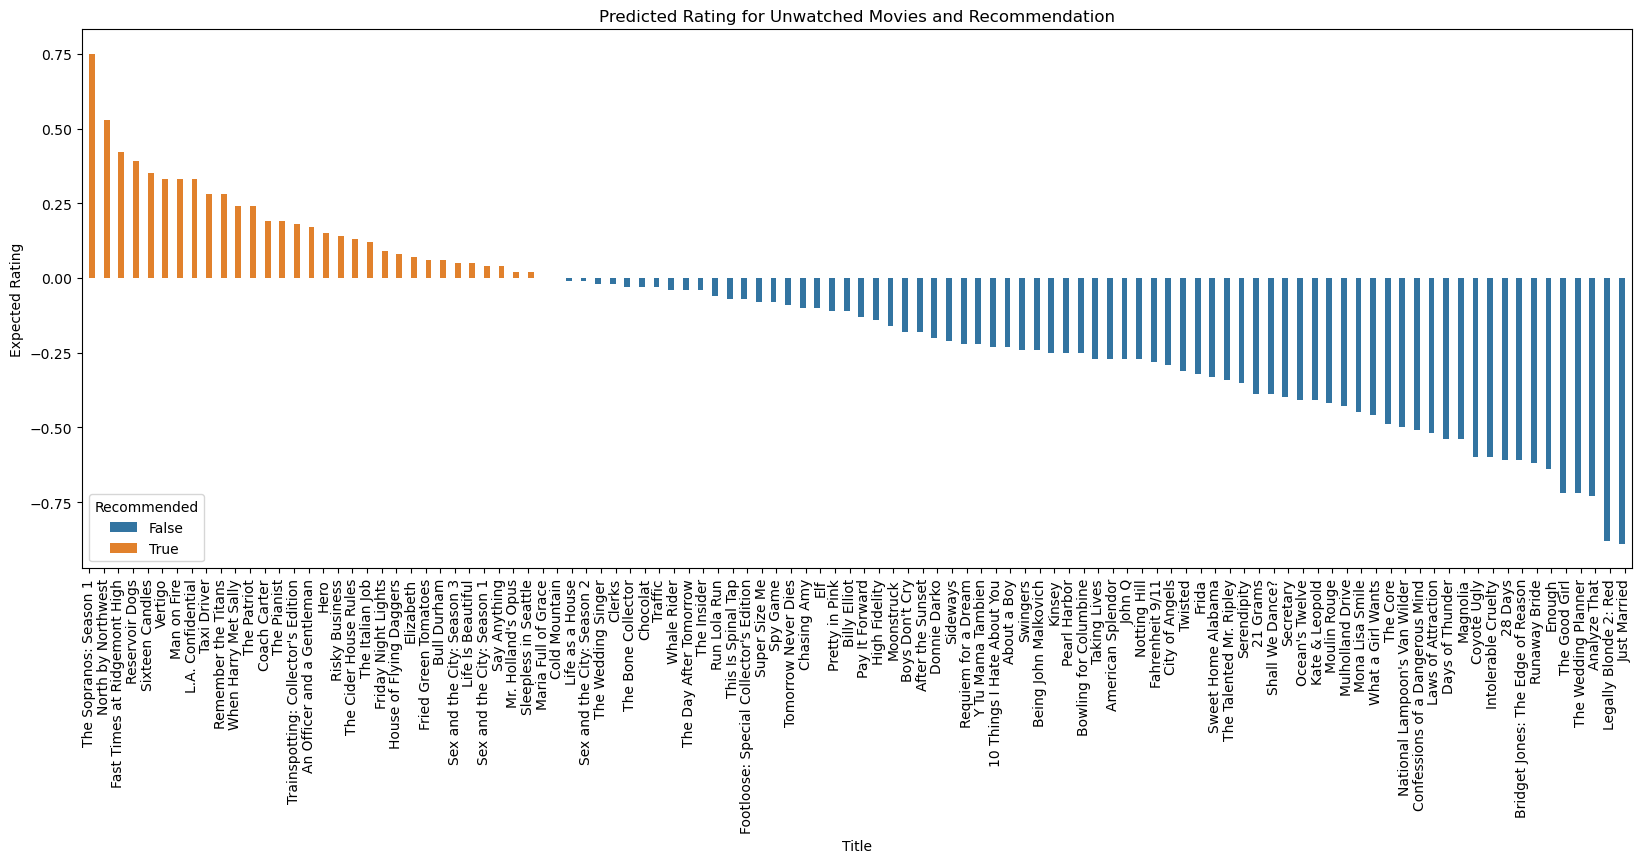

In [37]:
big_res1 = get_similarity(1, big_scaled_df)

In [39]:
big_res1[1]

,Title,Expected Rating,Recommended
89,The Sopranos: Season 1,0.75,True
2,North by Northwest,0.53,True
70,Fast Times at Ridgemont High,0.42,True
0,Reservoir Dogs,0.39,True
15,Sixteen Candles,0.35,True
90,Vertigo,0.33,True
11,Man on Fire,0.33,True
38,L.A. Confidential,0.33,True
43,Taxi Driver,0.28,True
87,Remember the Titans,0.28,True


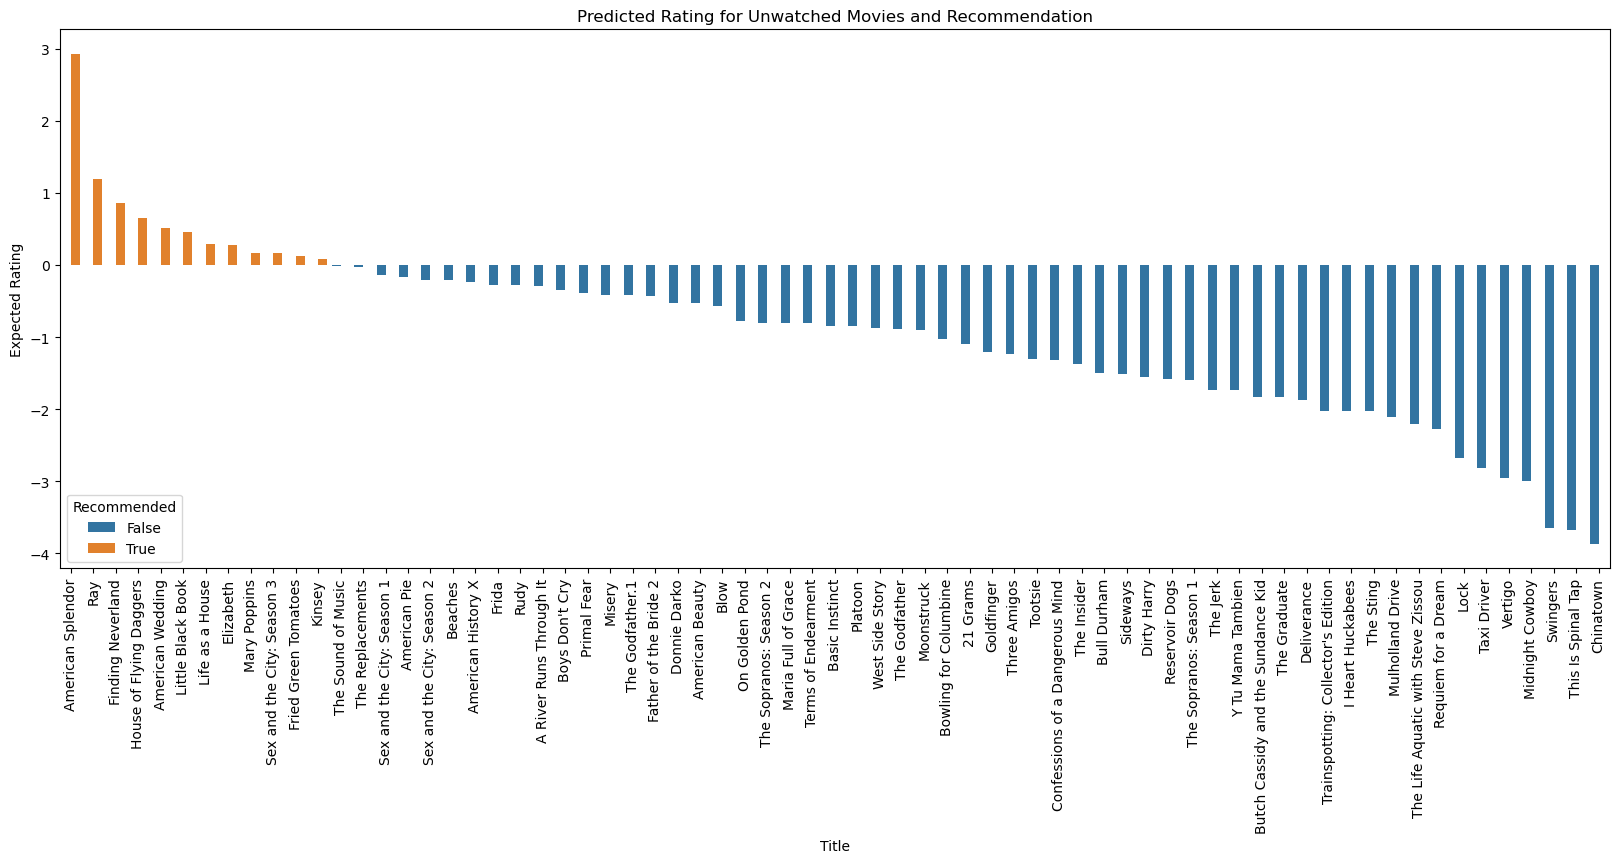

In [40]:
big_res2 = get_similarity(2, big_scaled_df)

In [41]:
big_res2[1]

,Title,Expected Rating,Recommended
59,American Splendor,2.93,True
3,Ray,1.19,True
14,Finding Neverland,0.86,True
39,House of Flying Daggers,0.66,True
6,American Wedding,0.52,True
66,Little Black Book,0.46,True
7,Life as a House,0.29,True
20,Elizabeth,0.28,True
45,Mary Poppins,0.17,True
28,Sex and the City: Season 3,0.17,True


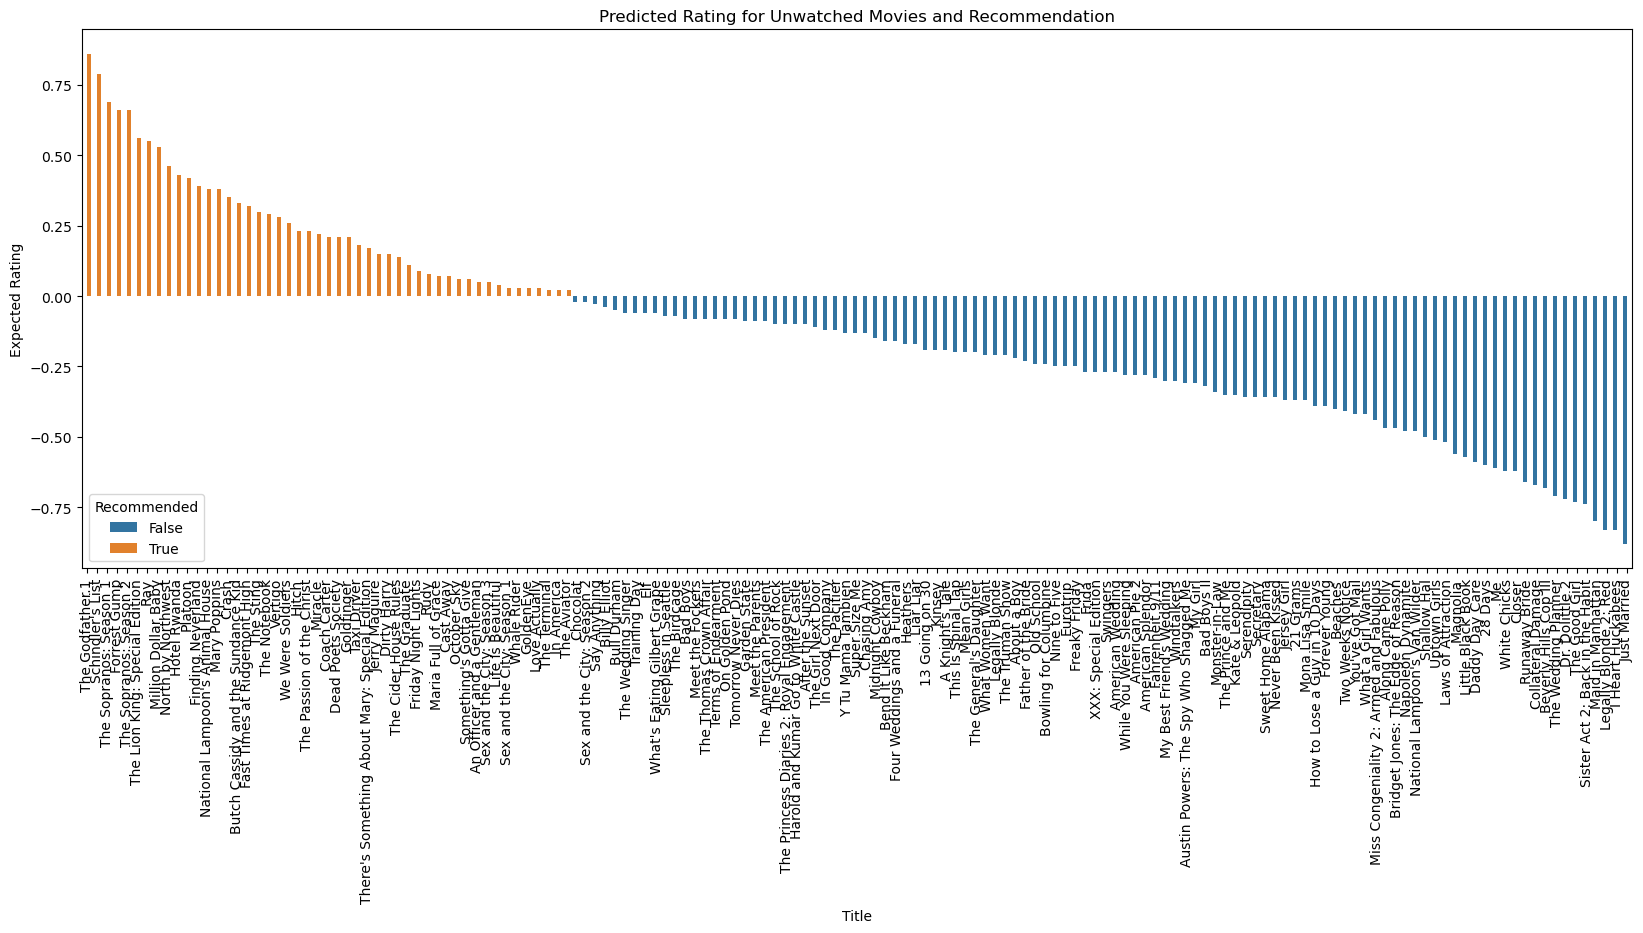

In [42]:
big_res3 = get_similarity(175, big_scaled_df)

In [43]:
big_res3[1]

,Title,Expected Rating,Recommended
82,The Godfather.1,0.86,True
87,Schindler's List,0.79,True
131,The Sopranos: Season 1,0.69,True
77,Forrest Gump,0.66,True
110,The Sopranos: Season 2,0.66,True
37,The Lion King: Special Edition,0.56,True
7,Ray,0.55,True
79,Million Dollar Baby,0.53,True
1,North by Northwest,0.46,True
78,Hotel Rwanda,0.43,True


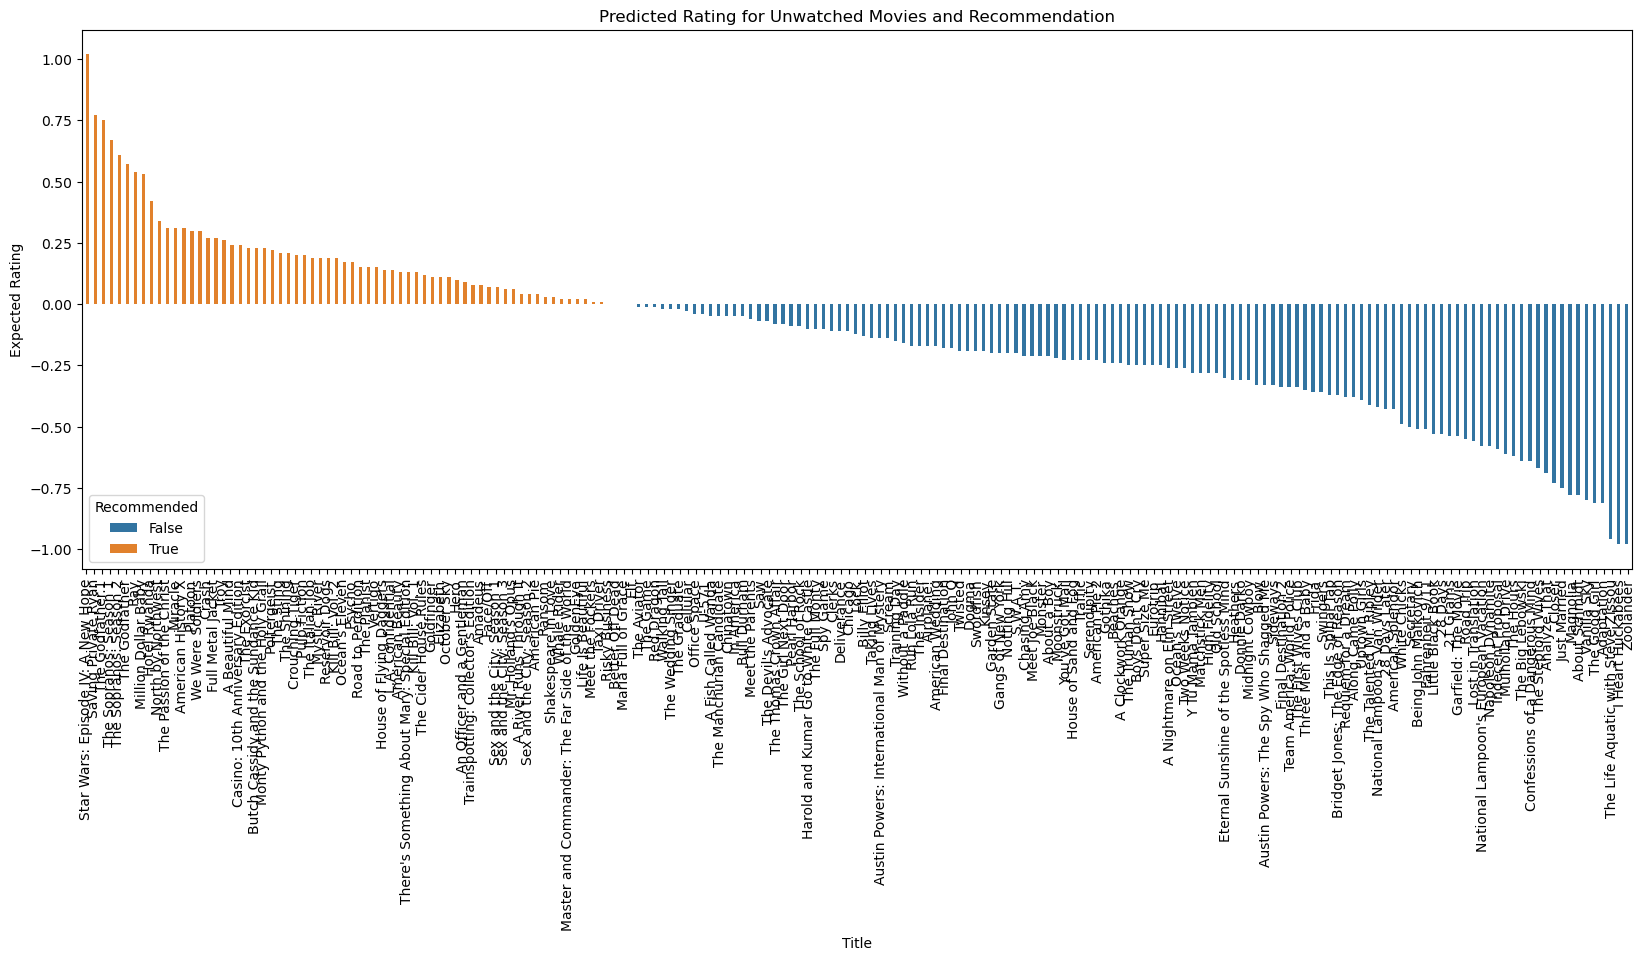

In [44]:
big_res4 = get_similarity(440, big_scaled_df)

In [45]:
big_res4[1]

,Title,Expected Rating,Recommended
161,Star Wars: Episode IV: A New Hope,1.02,True
182,Saving Private Ryan,0.77,True
101,The Godfather.1,0.75,True
159,The Sopranos: Season 1,0.67,True
132,The Sopranos: Season 2,0.61,True
41,The Godfather,0.57,True
13,Ray,0.54,True
94,Million Dollar Baby,0.53,True
91,Hotel Rwanda,0.42,True
3,North by Northwest,0.34,True


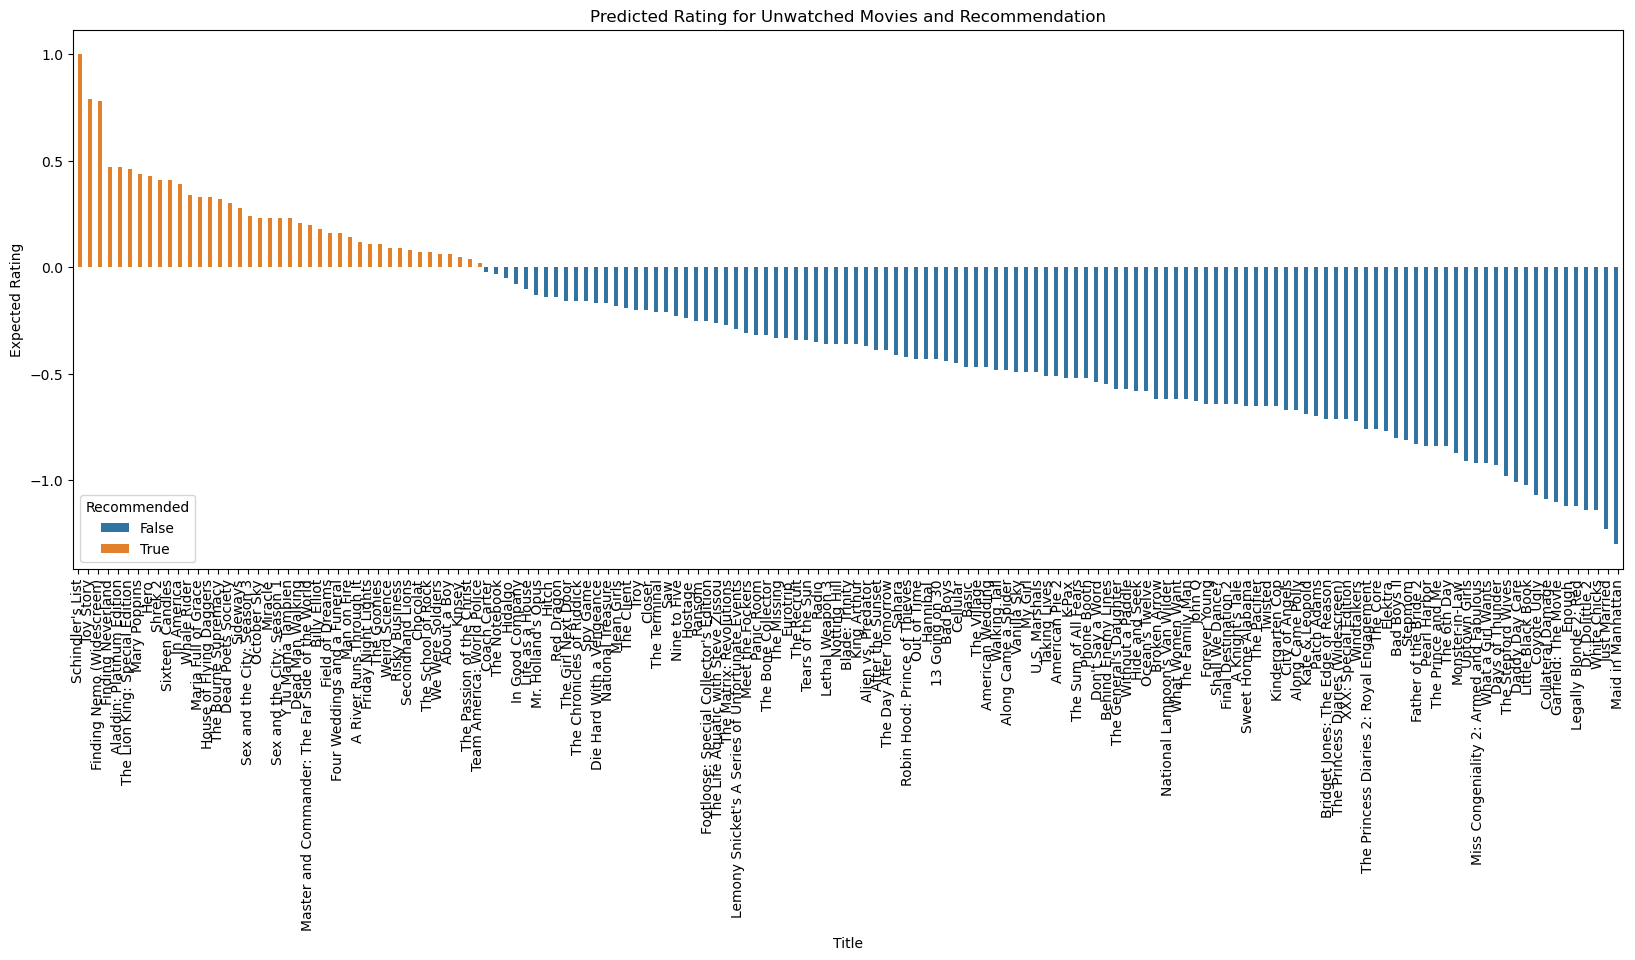

In [46]:
big_res5 = get_similarity(999, big_scaled_df)

In [48]:
big_res5[1]

,Title,Expected Rating,Recommended
91,Schindler's List,1.00,True
101,Toy Story,0.79,True
43,Finding Nemo (Widescreen),0.78,True
29,Finding Neverland,0.47,True
23,Aladdin: Platinum Edition,0.47,True
30,The Lion King: Special Edition,0.46,True
105,Mary Poppins,0.44,True
87,Hero,0.43,True
42,Shrek 2,0.41,True
17,Sixteen Candles,0.41,True


## Limitation

Since the quality of rating prediction heavily depends on the ratings of other users, collaborative filtering requires as many observations as possible. Small number of users produces biased results and sparse movie ratings for a movie gives small similarities among users, thus leading to imprecise prediction. On the other hand, since our main function for predicting rating has time complexity: $O(n^2)$, it is hard to run predictions for every single user, which takes a huge amount of time. Therefore, the more efficient methodology for rating prediction is desirable. Lastly, since collaborative filtering only compares the similarity between one user and the others, it does not consider the content side of things such as genre, director, and length of a movie. Hence, detailed and tailored recommendation might be difficult in that sense. In this regard, content-based recommendation can be implemented used. Ullman et al. (2014) provides a good explanation of that technique in their [book](http://infolab.stanford.edu/~ullman/mmds/ch9.pdf).